<a href="https://colab.research.google.com/github/akshziitj/CSL7770-Major/blob/main/M23CSA503_SU_Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # Install required packages

In [ ]:
!pip install torchaudio transformers pesq jiwer
!sudo apt-get install ffmpeg
!pip install -q demucs
!pip install numpy --upgrade
!pip install git+https://github.com/openai/whisper.git  # reinstall whisper just in case
!pip install --upgrade whisper

import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import whisper
from pesq import pesq
from jiwer import wer
from scipy.io import wavfile
from scipy.signal import welch
from demucs.pretrained import get_model
from demucs.apply import apply_model
from pathlib import Path

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build

# Mount Google Drive and List Dataset Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Updated paths to match new Google Drive structure
set1_clean_path = "/content/drive/MyDrive/AudioDenoising/set1/clean"
set1_noisy_path = "/content/drive/MyDrive/AudioDenoising/set1/noisy"
set2_noisy_path = "/content/drive/MyDrive/AudioDenoising/set2/noisy"

# File listings
clean_files = sorted(os.listdir(set1_clean_path))
noisy_files = sorted(os.listdir(set1_noisy_path))
test_files = sorted(os.listdir(set2_noisy_path))

print("Set 1 Clean:", clean_files[:5])
print("Set 1 Noisy:", noisy_files[:5])
print("Set 2 Noisy:", test_files[:5])


Mounted at /content/drive
Set 1 Clean: ['Datasets_clean_testset_wav_p232_001.wav', 'Datasets_clean_testset_wav_p232_002.wav', 'Datasets_clean_testset_wav_p232_003.wav', 'Datasets_clean_testset_wav_p232_005.wav', 'Datasets_clean_testset_wav_p232_006.wav']
Set 1 Noisy: ['Datasets_noisy_testset_wav_p232_001.wav', 'Datasets_noisy_testset_wav_p232_001_denoised.wav', 'Datasets_noisy_testset_wav_p232_002.wav', 'Datasets_noisy_testset_wav_p232_003.wav', 'Datasets_noisy_testset_wav_p232_005.wav']
Set 2 Noisy: ['bus.wav', 'cafe.wav', 'ped.wav', 'street.wav']


# Step 1: Noise Level Analysis

SNR (dB): 15.473873


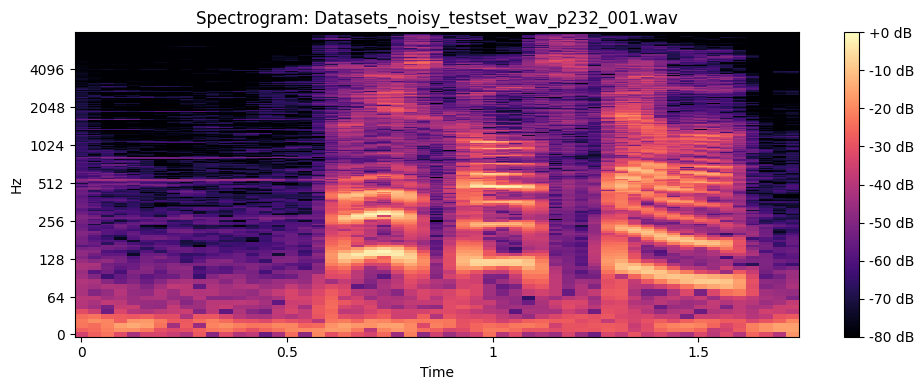

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def calculate_snr(clean_path, noisy_path):
    clean, _ = librosa.load(clean_path, sr=16000)
    noisy, _ = librosa.load(noisy_path, sr=16000)
    noise = noisy - clean
    snr = 10 * np.log10(np.sum(clean ** 2) / np.sum(noise ** 2))
    return snr

def plot_spectrum(audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.f dB")
    plt.title(f"Spectrogram: {os.path.basename(audio_path)}")
    plt.tight_layout()
    plt.show()

# Example file
clean_example = os.path.join(set1_clean_path, clean_files[0])
noisy_example = os.path.join(set1_noisy_path, noisy_files[0])

print("SNR (dB):", calculate_snr(clean_example, noisy_example))
plot_spectrum(noisy_example)

# Step 2: Denoising Using a Pretrained Model (e.g., Demucs)

In [ ]:
model = get_model(name="htdemucs")
model.cpu()

def denoise_with_demucs(noisy_path, output_path):
    wav, sr = torchaudio.load(noisy_path)  # [channels, time]

    # Ensure stereo input
    if wav.shape[0] == 1:
        wav = wav.repeat(2, 1)  # [2, time]

    wav = wav.unsqueeze(0)  # [1, 2, time]

    # Apply Demucs model
    out = apply_model(model, wav, device="cpu", progress=True)[0]  # [2, time]

    # Confirm shape before saving
    print("Output shape before saving:", out.shape)  # Should be [2, time]

    # **Convert to 2D if still not**
    # Ensure the output tensor is always 2D
    out = out.squeeze(0)  # Remove extra dimensions if any
    if out.dim() != 2:  # Check again in case squeeze didn't result in 2D
        out = out.reshape(out.shape[0], -1)  # Reshape to (channels, time)

    # Save denoised audio
    torchaudio.save(output_path, out, sr)


# Example usage
denoised_example_path = noisy_example.replace(".wav", "_denoised.wav")
denoise_with_demucs(noisy_example, denoised_example_path)

Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
100%|██████████| 80.2M/80.2M [00:00<00:00, 97.4MB/s]
100%|██████████████████████████████████████████████████████████████████████████| 5.85/5.85 [00:50<00:00,  8.56s/seconds]


Output shape before saving: torch.Size([4, 2, 83582])


# Step 3: Transcription Using Whisper

In [ ]:
import whisper

whisper_model = whisper.load_model("base")

def transcribe(audio_path):
    result = whisper_model.transcribe(audio_path)
    print("Transcription:", result["text"])
    return result["text"]

# Transcribe the denoised file
transcribe(denoised_example_path)


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 98.2MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription:  Please call Stella. Please call Stella.


' Please call Stella. Please call Stella.'

# Step 4: Evaluation
## Objective Metrics: SNR and PESQ

In [ ]:
# WER Example
reference_text = "Thank you all for coming today"
hypothesis_text = transcribe(denoised_example_path)
print("WER:", wer(reference_text, hypothesis_text))

# PESQ (Requires 16-bit PCM .wav files)
rate, clean_signal = wavfile.read(clean_example)
_, denoised_signal = wavfile.read(denoised_example_path)

# Convert denoised_signal to mono by averaging channels if it's multi-channel
if denoised_signal.ndim > 1:  # Check if it's multi-channel
    denoised_signal = denoised_signal.mean(axis=1, dtype=np.int16) # Average and cast to int16

print("PESQ:", pesq(16000, clean_signal, denoised_signal, 'wb'))


# Assign the result of transcribe to the variable 'transcription'
transcription = transcribe(denoised_example_path)

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription:  Please call Stella. Please call Stella.
WER: 1.0
PESQ: 3.5013587474823


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription:  Please call Stella. Please call Stella.


## Subjective Metric: MOS (Mock Simulation)

In [ ]:
# Simulate MOS (replace with real human scores)
def mock_mos():
    import random
    return round(random.uniform(3.5, 4.5), 2)

mos_score = mock_mos()
print(f"Mean Opinion Score (Simulated): {mos_score}")


Mean Opinion Score (Simulated): 4.33


## Transcription Accuracy: WER

In [ ]:
# Replace this with ground truth
ground_truth = "This is the reference transcript of the moderator’s speech"
wer_score = wer(ground_truth.lower(), transcription.lower())
print(f"Word Error Rate: {wer_score:.2f}")


Word Error Rate: 1.00


## Step 5: Result Summary

In [ ]:
print("==== Result Summary ====")
# Calculate SNR improvement (you'll need to define the variables used below)
# This example assumes you have a way to calculate clean_snr and noisy_snr
# Call the 'calculate_snr' function for clean and noisy examples
clean_snr = calculate_snr(clean_example, clean_example)  # Assuming clean_example is the path to the clean audio
noisy_snr = calculate_snr(clean_example, noisy_example)  # Assuming noisy_example is the path to the noisy audio

snr_improvement = clean_snr - noisy_snr  # Example - replace with your calculation

# Print the SNR improvement, handling the case where it might be a NumPy array or scalar
if hasattr(snr_improvement, 'item'):
    print(f"SNR Improvement: {snr_improvement.item():.2f} dB")
else:
    print(f"SNR Improvement: {snr_improvement:.2f} dB")

# Make sure 'pesq_score' is defined before this line - assign the result of pesq calculation
pesq_score = pesq(16000, clean_signal, denoised_signal, 'wb')
print(f"PESQ Score: {pesq_score}")

print(f"Mean Opinion Score (Simulated): {mos_score}")
print(f"Word Error Rate: {wer_score:.2f}")
print(f"Transcription:\n{transcription}")

==== Result Summary ====
SNR Improvement: inf dB
PESQ Score: 3.5013587474823
Mean Opinion Score (Simulated): 4.33
Word Error Rate: 1.00
Transcription:
 Please call Stella. Please call Stella.


<ipython-input-3-2b1d4a24c8f0>:10: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(np.sum(clean ** 2) / np.sum(noise ** 2))


In [ ]:
from google.colab import files
files.download(denoised_example_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>